# Exciton-Polaritons in Lattices

**by Dmitry R. Gulevich <br>
ITMO University, St Petersburg, Russia**

Python code to simulate exciton-polaritons in lattices.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import exp2d # my module
import imp
#imp.reload(exp2d) # reload exp2d after update

# 1. The model

In [2]:
### Constants
me=9.1e-31 # electron mass, kg
hbar=1.05e-34 # reduced Planck constant, J s

In [3]:
### Physical parameters
meff=5.0e-5*me # exciton-polariton effective mass, kg
Lconstant = 5.8 # lattice constant, micron
Rpillar = 1.5 # pillar radius, micron
UinmeV=0.-0.1*1j # meV
UoutmeV=10-0.5*1j # meV

In [35]:
### Numerical calculation parameters
M=20 # discretization, even number
Nbands=10 # number of bands to calculate
NBzones=4 # number of Brillouion zones to calculate

In [36]:
assert M%2==0
Mhalf=round(M/2)
E0=hbar*hbar/(2.*meff*Lconstant*Lconstant*1.e-12)/(1.6e-22) # characteristic energy, meV
dr=1./M
dr2=dr*dr

In [37]:
### Define potential in one unit cell
U = exp2d.U_Lieb(M, Rpillar/Lconstant, UinmeV/E0, UoutmeV/E0)

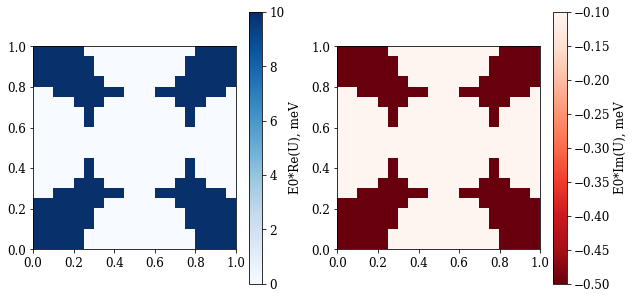

In [38]:
### Display potential
plt.rc('font', size=12)
fig,ax=plt.subplots(1,2,figsize=(10,5))
img0=ax[0].imshow(E0*U.real.T,cmap = plt.cm.Blues, extent=[0,1,0,1], origin='lower')
img1=ax[1].imshow(E0*U.imag.T,cmap = plt.cm.Reds_r, extent=[0,1,0,1], origin='lower')
plt.colorbar(img0,ax=ax[0],label='E0*Re(U), meV')
plt.colorbar(img1,ax=ax[1],label='E0*Im(U), meV')
plt.show()

# 2. Bloch states and band structure 

$$
-\Delta \psi_{n,\mathbf{k}}(\mathbf{r}) + \Re[U(x,y)] \,\psi_{n,\mathbf{k}}(\mathbf{r}) = E_n \psi_{n,\mathbf{k}}(\mathbf{r}),
$$

In [39]:
kxrange=np.linspace(-NBzones*np.pi, NBzones*np.pi, 70)

In [40]:
# Calculate bands at a fixed ky
%time evlist=exp2d.bands_at_ky(M, U, kxrange, 0., Nbands)

CPU times: user 1.43 s, sys: 12 ms, total: 1.44 s
Wall time: 727 ms


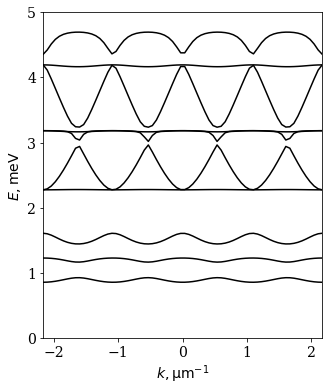

In [43]:
plt.rc('font', size=14)
fig, ax = plt.subplots(figsize=(5,6))
for i in range(evlist.shape[1]):
    ax.plot(kxrange/Lconstant,E0*evlist[:,i],'k')
ax.set_xlim([kxrange[0]/Lconstant,kxrange[-1]/Lconstant])
ax.set_ylim([0,5])
ax.set_xlabel(r"$k, \rm \mu m^{-1}$")
ax.set_ylabel(r"$E, \rm meV$")
plt.show()

In [44]:
# Calculate Bloch states at fixed (kx,ky)
%time evals,evecs = exp2d.calc_vectors(M, U, 0., 0., Nbands)

CPU times: user 38.3 ms, sys: 19 µs, total: 38.3 ms
Wall time: 22.1 ms


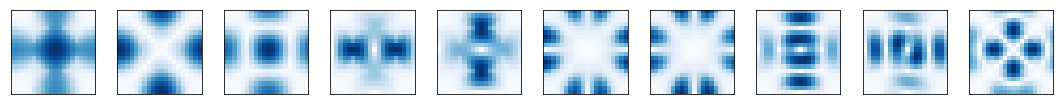

In [47]:
### Display Bloch states
fig, ax = plt.subplots(1,Nbands,figsize=(15,2))
for nv in range(Nbands):
    data=np.abs(evecs[nv]).reshape(M,M)
    ax[nv].imshow(data.T,interpolation='nearest', cmap = plt.cm.Blues, origin='lower')
    ax[nv].set_xticks([])
    ax[nv].set_yticks([])
plt.tight_layout()
plt.show()

# 3. Evolution from initial state

$$
i\frac{\partial\psi}{\partial t} = -\Delta \psi + \Re[U(x,y)]\,\psi + i\Im[U(x,y)]\,\psi, \quad \psi(\mathbf{r},0)=\psi_0(\mathbf{r})
$$

In [48]:
Ncells=8 # 12, integer number for symmetric display
Nframes=80 # 200
Nsamples=5 # 40
NPKY=6
Emin=0.5
Emax=5.2
dt=0.002 # timestep
kylist=np.array([0., 0.15, 0.44, 0.74, 1.03, 1.31]); # in um^-1

In [49]:
# Define potential in a supercell of Ncells x Ncells cells
Mglobal=Ncells*M
Uglobal=np.zeros((Mglobal,Mglobal),dtype=np.complex128)
for i in range(Ncells):
    for j in range(Ncells):
        Uglobal[i*M:(i+1)*M,j*M:(j+1)*M] = np.copy(U[:,:])

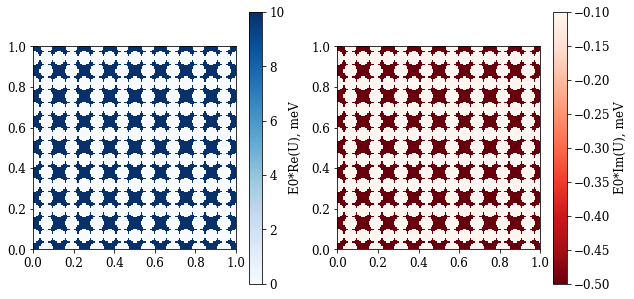

In [50]:
### Display potential
plt.rc('font', size=12)
fig,ax=plt.subplots(1,2,figsize=(10,5))
img0=ax[0].imshow(E0*Uglobal.real.T,cmap = plt.cm.Blues, extent=[0,1,0,1], origin='lower')
img1=ax[1].imshow(E0*Uglobal.imag.T,cmap = plt.cm.Reds_r, extent=[0,1,0,1], origin='lower')
plt.colorbar(img0,ax=ax[0],label='E0*Re(U), meV')
plt.colorbar(img1,ax=ax[1],label='E0*Im(U), meV')
plt.show()

In [51]:
dkx=2.*np.pi/Ncells
kmax=NBzones*np.pi
dtout = np.pi*E0/Emax # from the Nyquist frequency at Emax
countout=int(dtout/dt)
dE=2.*np.pi*E0/(Nframes*countout*dt)

In [52]:
import time
from scipy.sparse import csc_matrix
from scipy.sparse import dia_matrix
from scipy.sparse import linalg

# Loop over the BZ
#for n in range(Ncells):
# ky=-np.pi+n*dkx
    
krange = -np.pi + dkx*np.arange(Ncells)


### Constructing matrix
Imat=np.ones(M*M,dtype=np.complex128)
Itop=np.ones(M,dtype=np.complex128)
Itop[0]=0.
Itopmat=np.array([Itop]*M).ravel()
Ibot=np.ones(M,dtype=np.complex128)
Ibot[-1]=0.
Ibotmat=np.array([Ibot]*M).ravel()
offset=[-(M-1),-M*(M-1),-M,-1,0,1,M,M*(M-1),M-1]

Psi=np.zeros((Ncells*M,Ncells*M),dtype=np.complex128)
evecslist=[]

start_time = time.time()
    
for ky in krange: 

    eky=np.exp(-1j*ky)
    ekytop=np.zeros(M,dtype=np.complex128)
    ekybot=np.zeros(M,dtype=np.complex128)
    ekytop[-1]=-eky
    ekybot[0]=-np.conjugate(eky)
    topmat=np.array([ekytop]*M).ravel()
    botmat=np.array([ekybot]*M).ravel()

    for kx in krange:

        ekx=np.exp(-1j*kx)
        data=[botmat,-Imat*np.conjugate(ekx),-Imat,-Ibotmat,4.*Imat + dr2*U.real.ravel(),-Itopmat,-Imat,
              -Imat*ekx,topmat]
        dmatrix=dia_matrix((data, offset), shape=(M*M, M*M))
        spmatrix=csc_matrix(dmatrix)
        evalsunsorted,Tevecs=linalg.eigsh(spmatrix, return_eigenvectors=True, k=Nbands, sigma=0)
        evalsunsorted/=dr2
        evecsunsorted=Tevecs.T
    
        inds=np.argsort(evalsunsorted)
        evals=evalsunsorted[inds]
        evecs=evecsunsorted[inds]
        ens=E0*evals

        evecslist.append(evecs.ravel())
        
evecsarr=np.array(evecslist).reshape(Ncells,Ncells,Nbands,M*M)

print('#')
print("# Timing: %.f seconds" % (time.time()-start_time))
print('#')

#
# Timing: 1 seconds
#


In [33]:
from numpy.ctypeslib import ndpointer, load_library
from ctypes import *

### === C library interface ===
libcd = load_library("liblattice.so", ".")
libcd.evolve.restype = None
libcd.evolve.argtypes = [ndpointer(dtype=np.complex128, ndim=2, flags='C_CONTIGUOUS'), 
        ndpointer(dtype=np.complex128, ndim=3, flags='C_CONTIGUOUS'),
        c_int, c_int, c_double, c_int, c_int,
        ndpointer(dtype=np.complex128, ndim=2, flags='C_CONTIGUOUS'), 
        ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),  c_int]

# set number of OpenMP threads
libcd.omp_set_num_threads(2)

FPsiarr=np.empty((Nframes,NPKY,Mglobal),dtype=np.complex128)

probsum=np.zeros((NPKY,round(Emax/dE)-round(Emin/dE),
                  1+int(Mglobal*0.5+kmax/dkx)-int(Mglobal*0.5-kmax/dkx)), dtype=np.float64)

for sample in range(Nsamples):

    Psi=np.zeros((Mglobal,Mglobal),dtype=np.complex128)

    # Loop over BZ
    for n in range(Ncells):
        ky=-np.pi+n*dkx
        for m in range(Ncells):
            kx=-np.pi+m*dkx
            for nv in range(Nbands):

                psi=np.copy(evecsarr[n,m,nv].reshape(M,M))

                randphase = np.exp(1j*2.*np.pi*np.random.random_sample())
                for i in range(Ncells):
                    for j in range(Ncells):
                        Psi[i*M:(i+1)*M,j*M:(j+1)*M] += randphase*psi[:,:]*np.exp(1j*(kx*i+ky*j))

    libcd.evolve(Psi,FPsiarr,Ncells,Mhalf,dt,Nframes,countout,Uglobal,kylist*Lconstant,kylist.size)
    
    for Pky in range(NPKY):
        fftarr=np.fft.fftshift(np.fft.fft(FPsiarr[:,Pky,:],axis=0),axes=1)
        data=(fftarr*np.conjugate(fftarr)).real
        data1=data[::-1]
        data2=data1[round(Emin/dE):round(Emax/dE),int(Mglobal*0.5-kmax/dkx):int(Mglobal*0.5+kmax/dkx)+1]
        probsum[Pky,:,:] += data2
        
    print("# Sample %d: done" % sample)     

# Sample 0: done
# Sample 1: done
# Sample 2: done
# Sample 3: done
# Sample 4: done


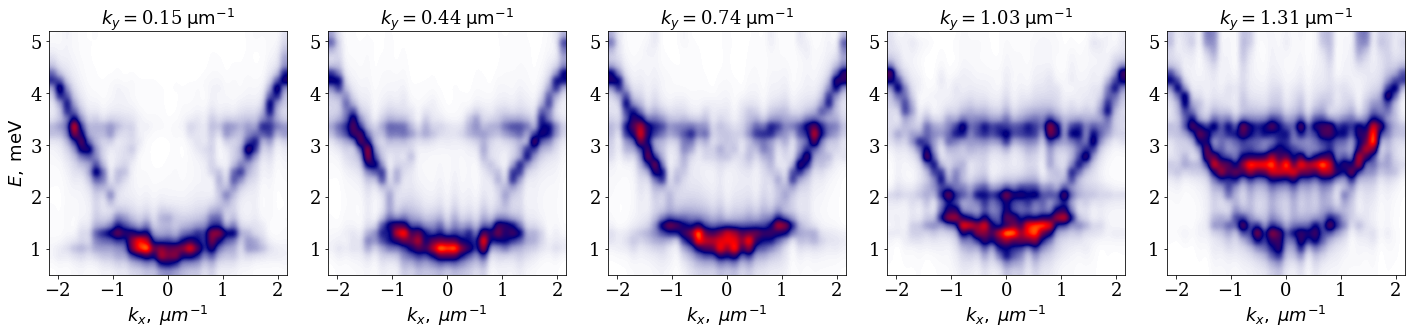

In [34]:
plt.rc('font', family='serif')
plt.rc('font', size='18')
fig, ax = plt.subplots(1, 5, figsize=(20,5))

for Pky in [1,2,3,4,5]:
    i=Pky-1
    img=ax[i].imshow(probsum[Pky],aspect='auto', interpolation='gaussian', 
                     extent=[-kmax/Lconstant,kmax/Lconstant,Emin,Emax], cmap = exp2d.mycmap, origin='lower')
    ax[i].set_xlabel(r'$k_x,\;\mu m^{-1}$')
    ax[i].set_xticks([-2,-1,0,1,2])
    ax[i].set_title(r'$k_y=$'+str(kylist[Pky])+r'$\rm\; \mu m^{-1}$', fontsize=18)
    #plt.colorbar(img,ax=ax[i])
    
ax[0].set_ylabel(r'$E,\;\rm meV$')

### ---  Overlay the band structure ---
# for Pky in [1,2,3,4,5]:
#     nax=Pky-1
#     ky = Lconstant*kylist[Pky] # normalized
#     evlist=exp2d.bands_at_ky(M, U, kxrange, ky, Nbands)
#     for i in range(evlist.shape[1]):
#         ax[nax].plot(kxrange/Lconstant,E0*evlist[:,i],'k')  
#     ax[nax].set_xlim([-kmax/Lconstant,kmax/Lconstant])
#     ax[nax].set_ylim([Emin,Emax])
#     ax[nax].set_xlabel(r"$k_x, \rm \mu m^{-1}$")
#     ax[nax].set_ylabel(r"$E, \rm meV$")

plt.tight_layout()

plt.show()

# Dynamics under the external drive

In [57]:
# import imp
# imp.reload(exp2d)

In [58]:
from numpy.ctypeslib import ndpointer, load_library
from ctypes import *

In [59]:
### === C library interface ===
libcd = load_library("liblattice.so", ".")
libcd.lattice.restype = None
libcd.lattice.argtypes = [ndpointer(dtype=np.complex128, ndim=2, flags='C_CONTIGUOUS'), ndpointer(dtype=np.complex128, ndim=2, flags='C_CONTIGUOUS'), 
        ndpointer(dtype=np.complex128, ndim=3, flags='C_CONTIGUOUS'), ndpointer(dtype=np.complex128, ndim=3, flags='C_CONTIGUOUS'),
        c_double, c_int, c_int, c_int, c_double, c_int, c_int, ndpointer(dtype=np.complex128, ndim=2, flags='C_CONTIGUOUS'), 
        ndpointer(dtype=np.float64, ndim=2, flags='C_CONTIGUOUS'), c_double, c_double, c_double, c_double, c_double,
                         c_double, c_double, c_double]

In [140]:
aratio=-0.05

beta0=0.2
Omega=0.3

dt=0.001
dtout=0.02
Nframes=50
countout=int(dtout/dt)

A0=200. # drive amplitude
omegadrive=0.35*(Emax/E0)
R=1.0

Nxcells=5 # integer number for symmetric display
Nycells=5 # integer number for symmetric display

#Nxcells=15 # integer number for symmetric display
#Nycells=5 # integer number for symmetric display

#M=38
M=20
MNx=M*Nxcells
MNy=M*Nycells

nR=np.zeros((MNx,MNy),dtype=np.float64)

#print('# Recommended dt: <<',1./Uout)
#print('# dt: %f, dtout: %f' % (dt,dtout))

Uglobal=np.zeros((MNx,MNy),dtype=np.complex128)
for i in range(Nxcells):
    for j in range(Nycells):
        Uglobal[i*M:(i+1)*M,j*M:(j+1)*M] = np.copy(U[:,:])    

Psi1=np.zeros((MNx,MNy),dtype=np.complex128)
Psi2=np.zeros((MNx,MNy),dtype=np.complex128)
Psi1data=np.empty((Nframes,MNx,MNy),dtype=np.complex128)
Psi2data=np.empty((Nframes,MNx,MNy),dtype=np.complex128)

In [141]:
#exec(open('Psic2.py').read())
libcd.lattice(Psi1,Psi2,Psi1data,Psi2data,1.,Nxcells,Nycells,Mhalf,dt,Nframes,countout,Uglobal,
              nR,aratio,beta0,Omega,A0,omegadrive,R,0.1,0.2)

In [142]:
def cpsi(Psi):
    interpolation='nearest'
    cmap=plt.get_cmap('Blues_r')
    data=(Psi*np.conjugate(Psi)).real
    img=plt.imshow(data.T,interpolation=interpolation, cmap = cmap, origin='lower')
    plt.colorbar(img,cmap=cmap)
    plt.show()

In [143]:
### Animation example: http://matplotlib.org/examples/animation/dynamic_image.html
import matplotlib.animation as animation

interpolation='nearest'
#interpolation='gaussian'
#interpolation=None

cmap=plt.get_cmap('Blues_r')

### --- Parameters ---

typicalframe = -1
rhomax=np.max(abs(Psi1data[typicalframe,:,:]*np.conjugate(Psi1data[typicalframe,:,:])))

fig, ax = plt.subplots(figsize=(18,6))
#fig, ax = subplots(figsize=(12,12))
#subplots_adjust(left=0, right=1, bottom=0, top=1)

data=(Psi1data[0,:,:]*np.conjugate(Psi1data[0,:,:])).real
im=plt.imshow(data.T,interpolation=interpolation, cmap = cmap, origin='lower',vmin=0,vmax=rhomax);

#ax.text(0.1, 0.1,'$t=$' + str(4.536),color='k')

def updatefig(frame):
    data=(Psi1data[frame,:,:]*np.conjugate(Psi1data[frame,:,:])).real
    im.set_array(data.T)
    return im,

def init():
    return updatefig(0)

#ani = animation.FuncAnimation(fig, updatefig, np.arange(1, Nframes), init_func=init, interval=500, blit=True, repeat=False)
ani = animation.FuncAnimation(fig, updatefig, np.arange(0, Nframes), init_func=init, interval=100, blit=False, repeat=False)

#fig.tight_layout()
#gca().set_aspect('equal', adjustable='box')
plt.axis('off')

#ani.save('the_movie.mp4', writer = 'ffmpeg', fps=15)
#ani.save('the_movie.mp4', writer = 'mencoder', fps=15)

plt.colorbar(im,cmap=cmap,label='colorbar')

plt.close(fig)

In [144]:
from IPython.display import HTML
HTML(ani.to_html5_video())